# **Course:** Introduction to Computer Vision (CS231.Q11)

**Topic:** Face Mask Classification

**Member:** 
- Nguyen Cong Phat - 23521143
- Nguyen Le Phong - 23521168
- Vu Viet Cuong - 23520213 

## --- STEP 1: DEFINE PATHS (Standard Kaggle Input Paths) ---

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define the base paths
base_dir = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

print("Libraries imported and paths defined.")

2025-11-30 02:53:32.770736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764471212.972122      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764471213.028368      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Libraries imported and paths defined.


## --- STEP 2: LOAD DATA ---

In [2]:
def load_data(directory):
    """
    Loads images from 'WithMask' (Label 0) and 'WithoutMask' (Label 1) folders.
    Returns normalized X (images) and Y (labels).
    """
    print(f"Loading data from {directory}...")
    
    data = []
    labels = []
    
    # Define categories explicitly to ensure consistent labeling
    # 0 = With Mask, 1 = Without Mask
    categories = {'WithMask': 0, 'WithoutMask': 1}
    
    for category, label in categories.items():
        path = os.path.join(directory, category)
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist.")
            continue
            
        files = os.listdir(path)
        
        for file in files:
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            
            if img is not None:
                # Resize to standard size
                img = cv2.resize(img, (128, 128))
                # Convert BGR (OpenCV standard) to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                data.append(img)
                labels.append(label)
    
    # Convert to numpy arrays
    X = np.array(data)
    Y = np.array(labels)
    
    # Shuffle the data (important for training!)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    
    # Normalize pixel values (0 to 1)
    X = X / 255.0
    
    print(f"Loaded {len(X)} images from {directory}")
    return X, Y

In [3]:
# 1. Load Training Data (Used for learning)
X_train, Y_train = load_data(train_dir)

# 2. Load Validation Data (Used for checking progress during training)
X_val, Y_val = load_data(val_dir)

# 3. Load Test Data (Used ONLY for final evaluation)
X_test, Y_test = load_data(test_dir)

print("\n--- Data Shapes ---")
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

Loading data from /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train...
Loaded 10000 images from /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train
Loading data from /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation...
Loaded 800 images from /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation
Loading data from /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test...
Loaded 992 images from /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test

--- Data Shapes ---
Train: (10000, 128, 128, 3)
Val:   (800, 128, 128, 3)
Test:  (992, 128, 128, 3)


## --- STEP 3: MODEL DEFINITION ---

In [10]:
import tensorflow as tf
import keras_tuner as kt

# 1. Define the model-building function
def build_model(hp):
    model = tf.keras.Sequential()
    
    # Input Layer
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))
    
    # --- TUNE 1: Convolutional Layers ---
    # We let the tuner decide: Should we use 32, 64, or 96 filters?
    hp_filters = hp.Int('filters_1', min_value=32, max_value=96, step=32)
    model.add(tf.keras.layers.Conv2D(hp_filters, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2,2))
    
    # Second Conv Layer (fixed or tunable)
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2,2))
    
    # Third Conv Layer
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2,2))
    
    model.add(tf.keras.layers.Flatten())
    
    # --- TUNE 2: Dense Layer Size ---
    # Try different neuron counts: 64, 128, or 256
    hp_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    model.add(tf.keras.layers.Dense(hp_units, activation='relu'))
    
    # --- TUNE 3: Dropout Rate ---
    # Try different dropout rates to find the sweet spot for overfitting
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout))
    
    # Output Layer
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    # --- TUNE 4: Learning Rate ---
    # This is crucial. We try 0.01 (fast), 0.001 (standard), and 0.0001 (precise)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## --- STEP 4: TUNING ---

In [11]:
# 2. Initialize the Tuner (Hyperband algorithm)
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,             # Maximum epochs per trial
    factor=3,
    directory='my_tuning_dir', # Folder to save results
    project_name='mask_detection_tuning'
)

# 3. Create a callback to stop bad trials early
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# 4. START THE SEARCH
print("--- Starting Hyperparameter Search ---")
tuner.search(X_train, Y_train, 
             epochs=10, 
             validation_data=(X_val, Y_val), 
             callbacks=[stop_early])

print("\n--- Search Complete ---")

Trial 30 Complete [00h 00m 45s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9975000023841858
Total elapsed time: 00h 13m 03s

--- Search Complete ---


## --- STEP 5: TRAINING ---

In [12]:
# 1. Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The search is complete.
Optimal Filters: {best_hps.get('filters_1')}
Optimal Dense Units: {best_hps.get('dense_units')}
Optimal Dropout: {best_hps.get('dropout')}
Optimal Learning Rate: {best_hps.get('learning_rate')}
""")

# 2. Build the model with these best parameters
best_model = tuner.hypermodel.build(best_hps)

# 3. Train this "Perfect" model fully
# We use EarlyStopping and ModelCheckpoint just like before
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

history = best_model.fit(
    X_train, Y_train,
    epochs=20, # Train longer now that we have the best settings
    validation_data=(X_val, Y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_hyper_mask_model.keras', save_best_only=True)
    ]
)


The search is complete.
Optimal Filters: 32
Optimal Dense Units: 192
Optimal Dropout: 0.4
Optimal Learning Rate: 0.0001

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8723 - loss: 0.3087 - val_accuracy: 0.9887 - val_loss: 0.0462
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9805 - loss: 0.0602 - val_accuracy: 0.9900 - val_loss: 0.0271
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9877 - loss: 0.0342 - val_accuracy: 0.9950 - val_loss: 0.0200
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9887 - loss: 0.0288 - val_accuracy: 0.9962 - val_loss: 0.0122
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9896 - loss: 0.0277 - val_accuracy: 0.9925 - val_loss: 0.0215
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9901 - loss: 0.0244 - val_accuracy: 0.9962 - val_loss: 0.0122
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9952 - loss: 0.0164 - val_accuracy: 0

## --- STEP 6: EVALUATION ---

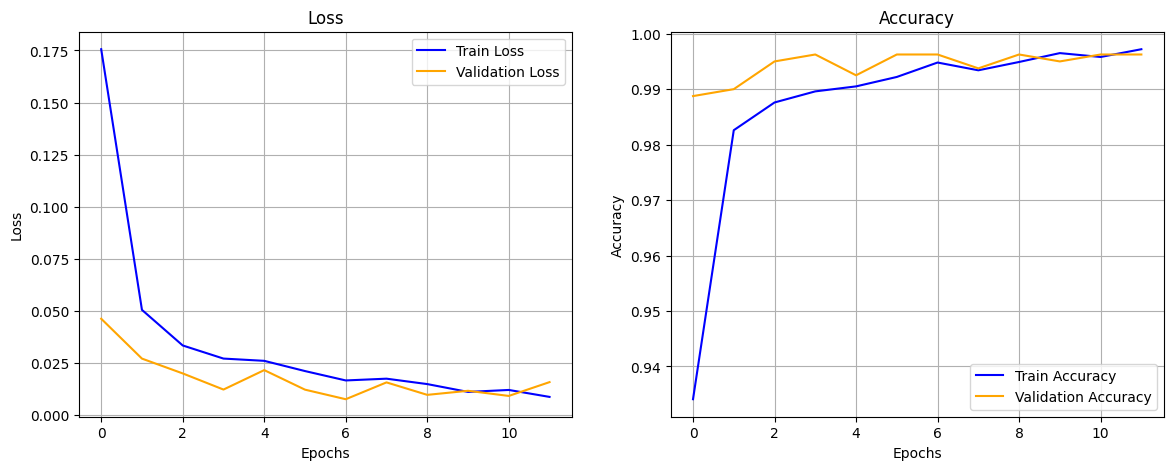

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- PART A: PLOT RESULTS ---
# Visualizing how the "Best Model" performed during training
plt.figure(figsize=(14, 5))

# 1. Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()


Generating predictions on the unseen Test Set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


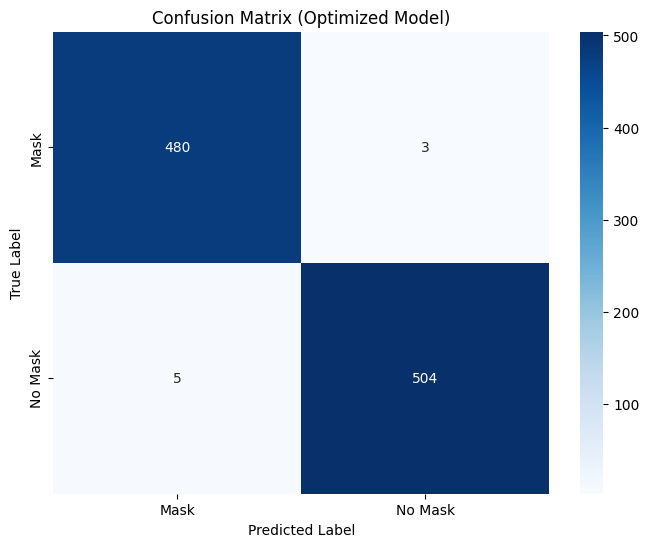


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Mask       0.99      0.99      0.99       483
     No Mask       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [15]:
# --- PART B: EVALUATION ON TEST SET ---
print("Generating predictions on the unseen Test Set...")

# Important: We use 'best_model' here, not the old 'model'
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- PART C: CONFUSION MATRIX ---
cm = confusion_matrix(Y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mask', 'No Mask'],
            yticklabels=['Mask', 'No Mask'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Optimized Model)')
plt.show()

# --- PART D: CLASSIFICATION REPORT ---
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(Y_test, y_pred_classes, target_names=['Mask', 'No Mask']))


In [16]:
# --- PART E: SAVE THE OPTIMIZED MODEL ---
# We give it a specific name so we know it's the tuned version
save_path = 'face_mask_detector_tuned.keras' 
best_model.save(save_path)

print(f"Optimized model saved successfully to: {save_path}")

Optimized model saved successfully to: face_mask_detector_tuned.keras
